In [1]:
import torch
from torch import nn
from torch import optim
from torchsummary import summary
from torch.nn import functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, random_split, DataLoader

import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw

torch.manual_seed(0)
np.random.seed(0)

In [2]:
with open('hyperparameters.yaml') as f:
    hp = yaml.safe_load(f)['hyperparameters']

In [3]:
base_path = './data/DermMel'

train_labels = pd.read_csv('./data/DermMel/train_labels.csv')
val_labels = pd.read_csv('./data/DermMel/val_labels.csv')
test_labels = pd.read_csv('./data/DermMel/test_labels.csv')

train_images = './data/DermMel/train/'
val_images = './data/DermMel/valid/'
test_images = './data/DermMel/test/'

In [4]:
train_labels.head()

,index,id,target
0,0,ISIC_0026529,0
1,1,AUG_0_3997,1
2,2,ISIC_0025285,0
3,3,ISIC_0033070,0
4,4,ISIC_0031685,0


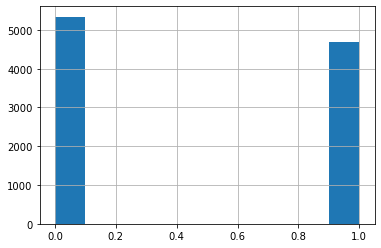

In [5]:
train_labels['target'].hist()

In [6]:
malignant_ids = train_labels.loc[train_labels['target'] == 1]['id'].values
benign_ids = train_labels.loc[train_labels['target'] == 0]['id'].values

print(f'Malignant: {malignant_ids[:15]}')
print(f'Normal: {benign_ids[:15]}')

Malignant: ['AUG_0_3997' 'AUGmented_0_6536' 'AUG_0_538' 'AUG_0_889'
 'AUGmented_0_8594' 'AUG_0_3968' 'AUG_0_3705' 'AUGmented_0_9575'
 'AUG_0_4955' 'AUGmented_0_8392' 'AUGmented_0_4221' 'AUG_0_9794'
 'AUG_0_4436' 'AUGmented_0_3310' 'AUG_0_1744']
Normal: ['ISIC_0026529' 'ISIC_0025285' 'ISIC_0033070' 'ISIC_0031685'
 'ISIC_0025945' 'ISIC_0026480' 'ISIC_0033720' 'ISIC_0028429'
 'ISIC_0033019' 'ISIC_0025574' 'ISIC_0026409' 'ISIC_0031825'
 'ISIC_0026673' 'ISIC_0028886' 'ISIC_0025801']


In [7]:
'''
this function scales down an image to 224 x 224 so that all images are uniform
in size, making it easy to feed to the model.

:param img: image used to scale down
'''
def scale_down(img):
    img = img.resize((int(img.size[0]/scale_factor), int(round(img.size[1]/scale_factor))))
    img = img.crop((37, 0, img.size[0] - 37, 224))
    return img

(224, 224)
(224, 224)
(224, 224)


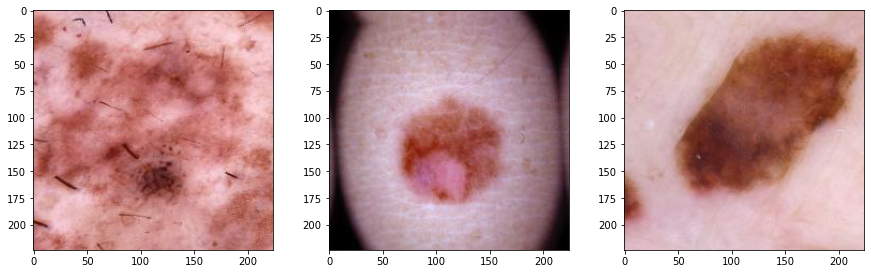

In [8]:
plt.rcParams['figure.figsize'] = (15., 15.)

for m_index, m_id in enumerate(malignant_ids[:3]):
    path = os.path.join(train_images, m_id + '.jpeg')
    img = Image.open(path)
    print(img.size)

    plt.subplot(3, 3, m_index + 1)
    plt.imshow(np.array(img))

(224, 224)
(224, 224)
(224, 224)


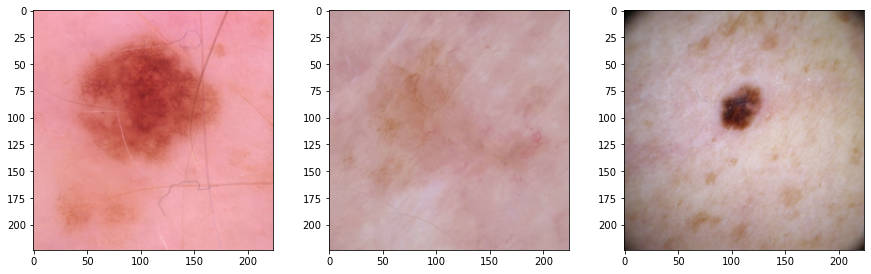

In [9]:
for m_index, m_id in enumerate(benign_ids[:3]):
    path = os.path.join(train_images, m_id + '.jpg')
    img = Image.open(path)

    scale_factor = img.size[1] / 224

    img = img.resize((int(img.size[0]/scale_factor), int(round(img.size[1]/scale_factor))))
    img = img.crop((37, 0, img.size[0] - 37, 224))

    print(img.size)
    plt.subplot(3, 3, m_index + 1)
    plt.imshow(np.array(img))

In [41]:
class MelanomaDataset(Dataset):
    def __init__(self, transform, type, csv: pd.DataFrame):
        path = os.path.join(base_path, type)
        filenames = os.listdir(path)
        self.full_filenames = [os.path.join(path, file) for file in filenames]
        labels_df = csv
        labels_df.set_index(['id'])

        self.csv = csv
        self.labels = labels_df['target']
        self.transform = transform

    def __len__(self):
        return len(self.csv) # 10020

    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        if image.size[0] == 600:
            image = scale_down(image)
        image = self.transform(image)
        return image, self.labels[idx]

In [42]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [43]:
train_ds = MelanomaDataset(transform, 'train', train_labels)
val_ds = MelanomaDataset(transform, 'valid', val_labels)

In [44]:
x = 231
print(train_ds.__getitem__(x)[0].shape)
print(train_ds.__getitem__(x)[1])

print(val_ds.__getitem__(x)[0].shape)
print(val_ds.__getitem__(x)[1])

torch.Size([3, 224, 224])
0
torch.Size([3, 224, 224])
1


In [45]:
print(f'Length of training dataset: {len(train_ds)}')
print(f'Length of validation dataset: {len(val_ds)}')

Length of training dataset: 10021
Length of validation dataset: 3349


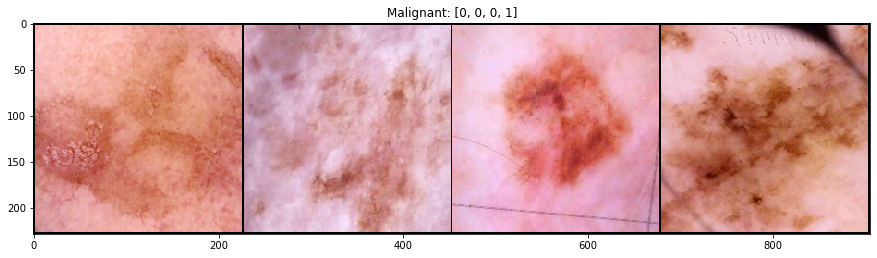

In [49]:
def show_img(img, labels):
    img = img.numpy()
    img = img.transpose(1, 2, 0)
    plt.imshow(img, interpolation='nearest')
    plt.title(f'Malignant: {labels}')

rand_i = np.random.randint(0, len(train_ds), 4)
imgs = [train_ds[i][0] for i in rand_i]
labels = [train_ds[i][1] for i in rand_i]

imgs = utils.make_grid(imgs, nrow=4)
plt.rcParams['figure.figsize'] = (15.0, 5)
show_img(imgs, labels)

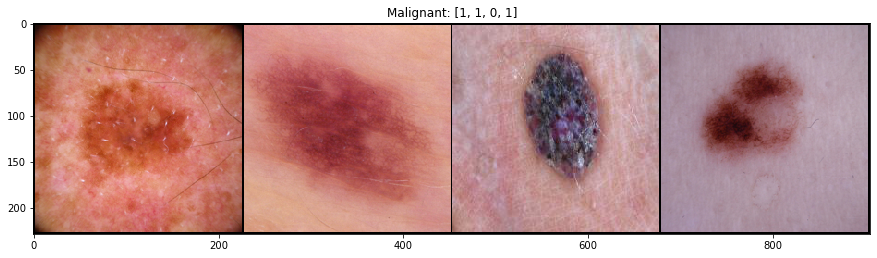

In [50]:
rand_i = np.random.randint(0, len(val_ds), 4)

imgs = utils.make_grid([val_ds[i][0] for i in rand_i], nrow=4)
labels = [val_ds[i][1] for i in rand_i]
show_img(imgs, labels)

In [51]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.5)
    , transforms.RandomVerticalFlip(p=.5)
    , transforms.RandomRotation(45)
    , transforms.RandomResizedCrop(96, (0.8, 1.0), ratio=(1., 1.))
    , transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToTensor()
])